In [1]:
# import all the necessary packages for evaluation
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch_cluster import random_walk
from sklearn.linear_model import LogisticRegression
import networkx as nx
import seaborn as sns
import random
import pylab as py
from sklearn.metrics import f1_score
# from sklearn.multiclass import OneVsRestClassifier #import this for multiclass classification (like PPI dataset)
from sklearn.svm import SVC
import scipy.sparse as sp
import warnings
warnings.filterwarnings("ignore")

In [2]:
from models.DeepWalk_Unigram import DeepWalk_Unigram
from models.DeepWalk_DNS import DeepWalk_Linear
from scripts.plot_settings import global_settings
global_settings() # dont call this if you don't have latex installed in your device
from scripts.load import load_data, load_shrtst_dist_matrix

In [3]:
# data folder
data_folder = './data/CiteSeer'
# saved model folder
model_folder = 'saved_models/CiteSeer'
# context windows to evaluate
context_windows = np.arange(16)[2:]
# number of runs
runs = 5

In [4]:
data, edgelist, y, train_mask, test_mask, val_mask = load_data(data_folder)
shrtst_dist, G = load_shrtst_dist_matrix(edgelist=edgelist, is_available=True, folder_name=data_folder)

Data Loaded!


In [5]:
# Specify the cuda; if not available it will use cpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = data.to(device)
print(device)

cuda:0


In [6]:
# load the F1-macro score from the saved models
# for DeepWalk UNS model

uns_acc = []
for ci in context_windows:
    print('For context window: ', ci, end='; ')
    macro_acc = []
    for run in range(runs):
        model_name = model_folder+'/UNS/cw_'+str(ci)+'_run_'+str(run)+'.pt'
        model = torch.load(model_name)
        model.eval()
        with torch.no_grad():
            z = model(torch.arange(data.num_nodes, device=device))
        test_f1_mac, _ = model.test_predict_f1(z[data.train_mask], data.y[data.train_mask],
                                 z[data.test_mask], data.y[data.test_mask], max_iter=150)
        
        macro_acc.append(test_f1_mac)    
    uns_acc.append(macro_acc)
    
#             for multiclass classification : use the following snipet instead of the model.test_predict_f1

#             z_train = z.data.cpu().numpy()[train_mask]
#             z_test = z.data.cpu().numpy()[test_mask]
#             y_train = data.y.data.cpu().numpy()[train_mask]
#             y_test = data.y.data.cpu().numpy()[test_mask]
#             clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', multi_class='auto')).fit(z_train, y_train)
#             y_p = clf.predict(z_test).ravel()
#             y_t = y_test.ravel()

#             test_f1_mac = f1_score(y_t, y_p, average='macro')
        

For context window:  2; For context window:  3; For context window:  4; For context window:  5; For context window:  6; For context window:  7; For context window:  8; For context window:  9; For context window:  10; For context window:  11; For context window:  12; For context window:  13; For context window:  14; For context window:  15; 

In [7]:
# load the F1-macro score from the saved models
# for DeepWalk DNS model

dns_acc = []
for ci in context_windows:
    print('For context window: ', ci, end='; ')
    macro_acc = []
    for run in range(runs):
        model_name = model_folder+'/DNS/cw_'+str(ci)+'_run_'+str(run)+'.pt'
        model = torch.load(model_name)
        model.eval()
        with torch.no_grad():
            z = model(torch.arange(data.num_nodes, device=device))
        test_f1_mac, _ = model.test_predict_f1(z[data.train_mask], data.y[data.train_mask],
                                 z[data.test_mask], data.y[data.test_mask], max_iter=150)
        macro_acc.append(test_f1_mac)    
    dns_acc.append(macro_acc)
    
#             for multiclass classification : use the following snipet instead of the model.test_predict_f1

#             z_train = z.data.cpu().numpy()[train_mask]
#             z_test = z.data.cpu().numpy()[test_mask]
#             y_train = data.y.data.cpu().numpy()[train_mask]
#             y_test = data.y.data.cpu().numpy()[test_mask]
#             clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', multi_class='auto')).fit(z_train, y_train)
#             y_p = clf.predict(z_test).ravel()
#             y_t = y_test.ravel()

#             test_f1_mac = f1_score(y_t, y_p, average='macro')

For context window:  2; For context window:  3; For context window:  4; For context window:  5; For context window:  6; For context window:  7; For context window:  8; For context window:  9; For context window:  10; For context window:  11; For context window:  12; For context window:  13; For context window:  14; For context window:  15; 

In [8]:
def get_mean_std(list_):
    mean_list = []
    std_list = []
    for acc_list in list_:
        mean_list.append(np.mean(acc_list))
        std_list.append(np.std(acc_list))
    return mean_list, std_list

In [9]:
unigram_y, unigram_yerr = get_mean_std(uns_acc)
linear_y, linear_yerr = get_mean_std(dns_acc)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


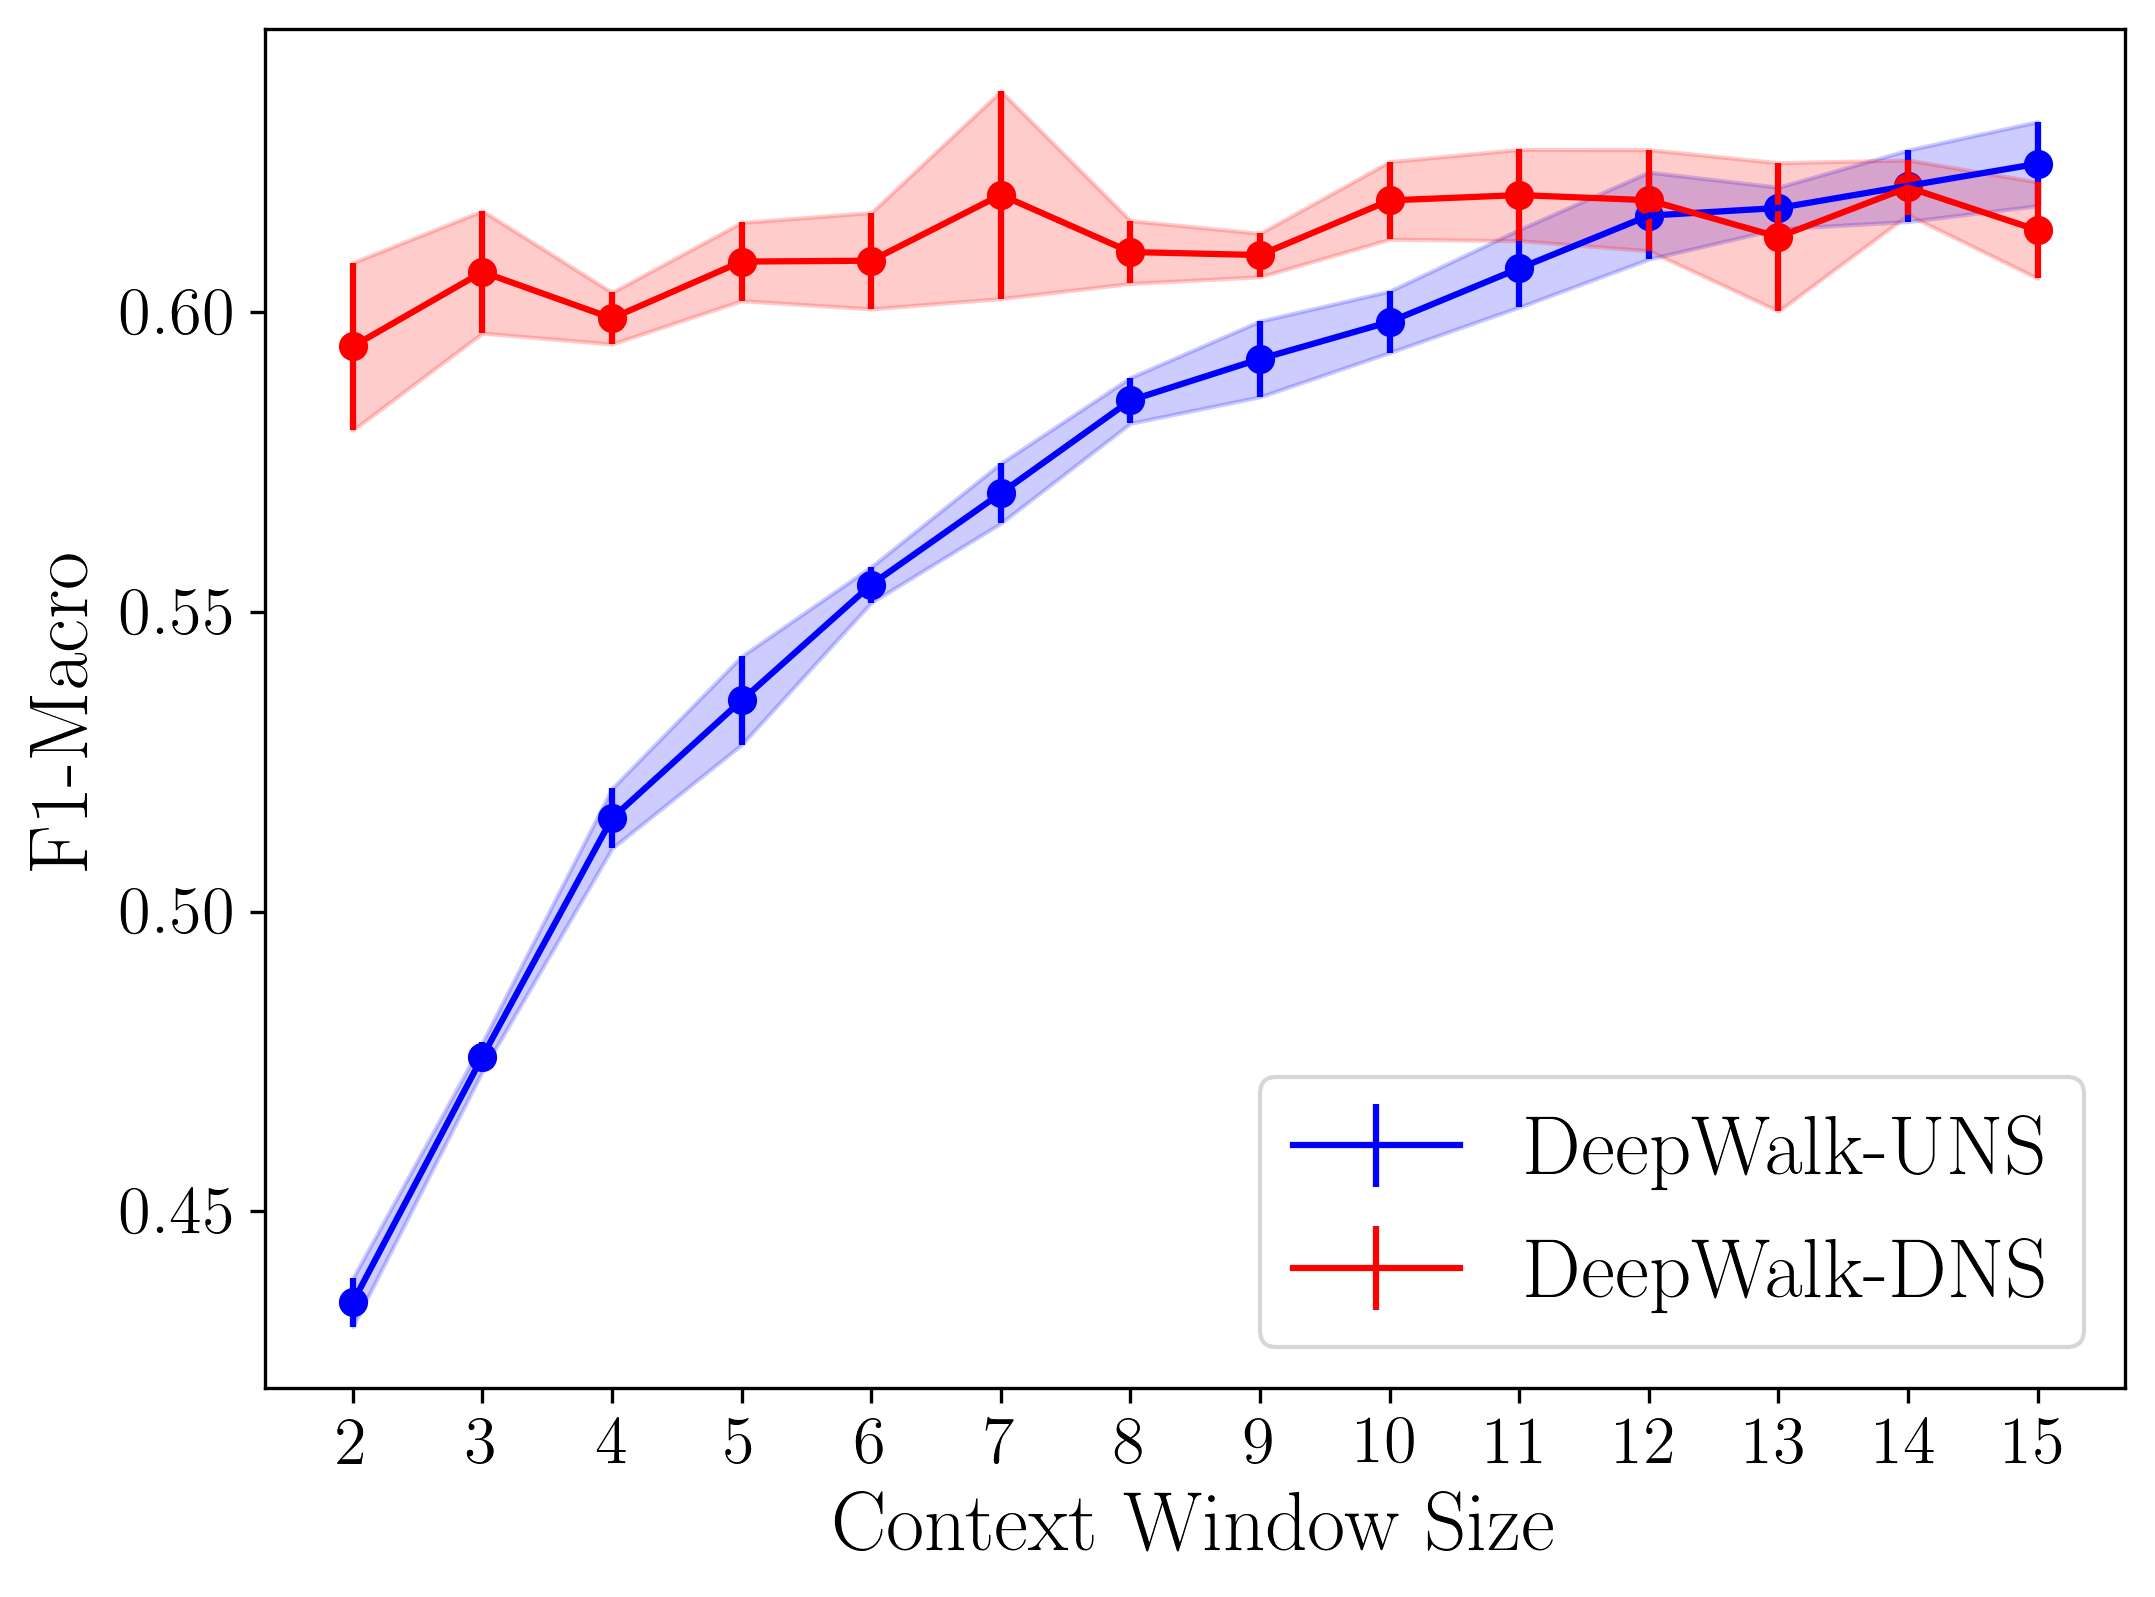

In [10]:
# Plotting the F1-Score with varying context window sizes

fig, ax = plt.subplots(figsize=(8, 6))
plt.fill_between(np.arange(len(unigram_y)), (np.array(unigram_y)-np.array(unigram_yerr)), (np.array(unigram_y)+np.array(unigram_yerr)), alpha=0.2, color='b')
plt.fill_between(np.arange(len(unigram_y)), (np.array(linear_y)-np.array(linear_yerr)), (np.array(linear_y)+np.array(linear_yerr)), alpha=0.2, color='r')
plt.errorbar(np.arange(len(unigram_y)), unigram_y, unigram_yerr, color='b', label='DeepWalk-UNS')
plt.errorbar(np.arange(len(linear_y)), linear_y, linear_yerr, color='r', label='DeepWalk-DNS')
plt.scatter(np.arange(len(unigram_y)), unigram_y, color='b')
plt.scatter(np.arange(len(linear_y)), linear_y, color='r')

py.legend(loc='lower right')
plt.xlabel(r'Context Window Size')
plt.xticks(np.arange(len(unigram_y)), context_windows)
plt.ylabel(r'F1-Macro')
plt.show()